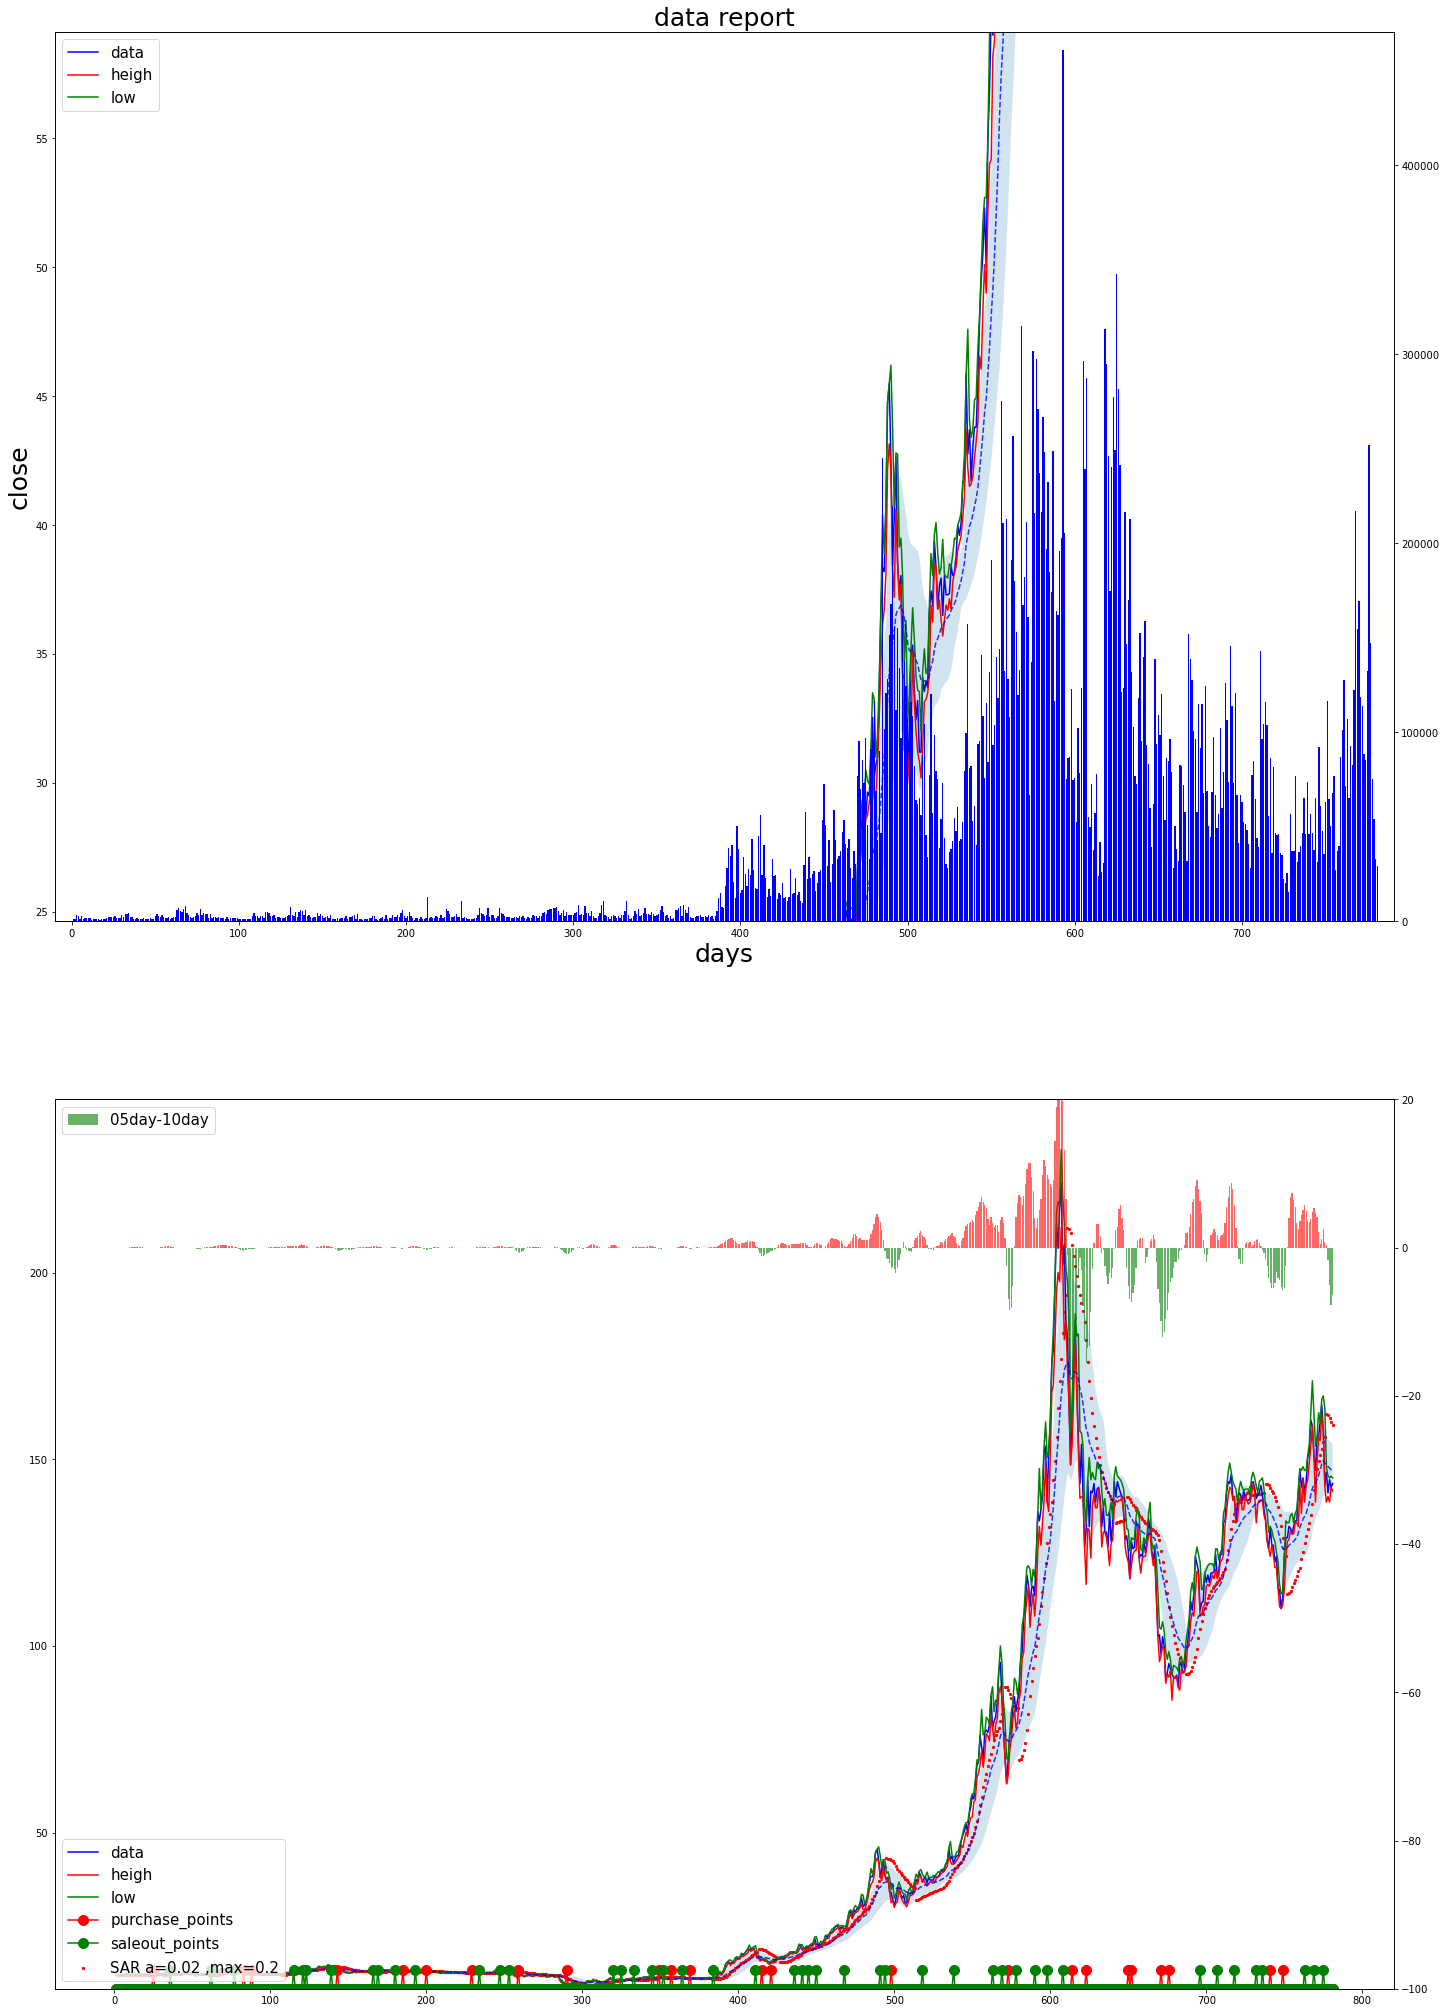

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob # 類似開啟檔案的動作
import talib
from talib import abstract

class stock:
    def __init__(self,):
        pass
    def load_df(self,csv_paths = './2603_from_20190101_to_20220301.xlsx'):
        df = pd.read_excel(csv_paths)
        df['收盤價'] = df['收盤價'].apply( lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['最低價'] = df['最低價'].apply( lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['最高價'] = df['最高價'].apply( lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['成交筆數'] = df['成交筆數'].apply( lambda x:float(x.replace(',','')) if type(x)==str else x )
        df['MA05_rolling'] = df['收盤價'].rolling(5).mean()
        df['MA10_rolling'] = df['收盤價'].rolling(10).mean()
        df['MA20_rolling'] = df['收盤價'].rolling(20).mean()
        df['close']= df['收盤價']
        df['high']= df['最高價']
        df['low']= df['最低價']
        return df

    def cal_talib(self,df):
        global sar , ACCELERATION , MAXIMUM
        df['EMA12'] = talib.EMA(np.array(df['收盤價']),timeperiod = 12)
        df['EMA26'] = talib.EMA(np.array(df['收盤價']),timeperiod = 26)
        df['MACD_DIF'] , df['MACD_DEA'] , df['MACDhist'] = talib.MACD(np.array(df['收盤價']),
                                                                  fastperiod = 6,
                                                                  slowperiod = 12,
                                                                  signalperiod = 9)
        ACCELERATION = 0.02
        MAXIMUM = 0.2 
        sar = talib.SAR(np.array(data_range_heigh),
                        np.array(data_range_low),
                         acceleration = ACCELERATION,
                         maximum = MAXIMUM)
        df['SAR'] = sar
        BBAND20 = abstract.BBANDS(df,timeperiod = 20 , nbdevup = 1.0 ,nbdevdn = 1.0 , matype = 1)
        STOCH = abstract.STOCH(df)
        return df , BBAND20 , STOCH

    def transfor_df_2_list(self,df):
        data_range_close = df['收盤價'].tolist()
        data_range_heigh = df['最低價'].tolist()
        data_range_low   = df['最高價'].tolist()
        data_values      = df['成交筆數'].tolist()
        return data_range_close ,data_range_heigh , data_range_low , data_values
    def strategy(self, df , STOCH , BBAND20):
        global SIGL_B , SIGL_S
        # 策略:
        # 建立一個買進的訊號: KD 在低檔(小於25)金叉, 且收價仍在布通道中線以下
        #(k小於25) 且 (當日k>d) 且(昨日k<d) <==昨日的比較方式,是用shift  ,且 (收盤價,會在布林中線以下)
        SIGL_B = (STOCH['slowk']<25) & (STOCH['slowk']> STOCH['slowd']) & (STOCH['slowk'].shift()< STOCH['slowd'].shift()) & (df['close']<=BBAND20['middleband'])
        # print(SIGL_B.tolist())
        #===========================================================================================================
        #建立一個賣出訊號: 昨日收盤在布林通道上緣, 今日收盤卻跌落布林通道上緣 
        SIGL_S = (df['close']<BBAND20['upperband']) & (df['close'].shift() > BBAND20['upperband'].shift())
        #建立一個賣出訊號: 當SAR 昨日在收盤價以下時,今日卻跳到收盤價以上 
        SIGL_S2 = (df['SAR']>df['close']) & (df['SAR'].shift()<df['close'].shift())
        

    def plot_stock(self , df ,BBAND20 , STOCH, data_range_close ,data_range_heigh ,
                   data_range_low , data_values , plot_page = 2,save_path='./stock_1.jpg'):
        t = t = np.linspace(1,len(data_range_close) , len(data_range_close))
        fig = plt.figure(figsize=(24,36)) #給一張大圖
        #==========================開始畫第一張子圖=====================================
        ax1 = plt.subplot(211) #畫子圖
        ax1.set_xlim(-10,len(t)+10)
        ax1.set_ylim(df['收盤價'].mean()*0.5 , df['收盤價'].mean()*1.2)# 把數據往上呈現一點

        ax1.plot(t,data_range_close , color = 'blue' , label='data')#畫數據
        ax1.plot(t,data_range_heigh , color = 'red'  , label='heigh')
        ax1.plot(t,data_range_low   , color = 'green', label='low')
        #畫布林帶
        ax1.plot(t,BBAND20['middleband'], color = 'blue' , linestyle = '--',alpha = 0.8)
        ax1.fill_between(t, BBAND20['lowerband'],BBAND20['upperband'] , alpha = 0.2)

        ax1.set_xlabel('days' ,  fontsize = 25)
        ax1.set_ylabel('close' , fontsize = 25)

        ax1.set_title('data report', fontsize = 25)
        # 畫第二個軸
        ax1_2 = ax1.twinx()
        ax1_2.bar(t,data_values , color = 'blue', label = 'Trading volume')
        ax1_2.set_ylim(0 , np.array(df['成交筆數']).mean()*10)# 把數據往上呈現一點

        ax1.legend(loc = 2 , prop = {'size':15})
        #==========================開始畫第二張子圖=====================================
        if plot_page == 2:
            ax2 = plt.subplot(212) #畫子圖

            ax2.plot(t,data_range_close , color = 'blue' , label='data')#畫數據
            ax2.plot(t,data_range_heigh , color = 'red'  , label='heigh')
            ax2.plot(t,data_range_low   , color = 'green', label='low')
            ax2.plot(t,BBAND20['middleband'], color = 'blue' , linestyle = '--',alpha = 0.8)
            ax2.fill_between(t, BBAND20['lowerband'],BBAND20['upperband'] , alpha = 0.2)
            ax2.scatter(t, sar ,s=5, color = 'red', label=f'SAR a={ACCELERATION} ,max={MAXIMUM}')

            ax2.set_ylim(df['收盤價'].min()*0.9 , df['收盤價'].max()*1.1)# 把數據往上呈現一點
            #畫買點的圖
            ax2.plot(t,[df['收盤價'].min()*0.9 if b==False else df['收盤價'].min()*0.9+5 for b in SIGL_B], 'r-o',markersize = 10 ,label = 'purchase_points')
            #畫賣點的圖
            ax2.plot(t ,[df['收盤價'].min()*0.9 if s==False else df['收盤價'].min()*0.9+5 for s in SIGL_S] , 'g-o',markersize = 10 ,label = 'saleout_points')
            ax2.legend(loc = 3 , prop = {'size':15})

            ax2_2 = ax2.twinx() #畫bar 
            ax2_2.bar(  t, df['MA05_rolling']-df['MA10_rolling'], 
                        color = ['red' if i>0 else 'green' for i in df['MA05_rolling']-df['MA10_rolling']],
                        alpha = 0.6,
                        label = '05day-10day' )
            ax2_2.set_ylim(-100,20)# 把數據往上呈現一點
            ax2_2.legend(loc = 2 , prop = {'size':15})
        plt.savefig(save_path)
        plt.show(fig)

if __name__ == '__main__':
    S=stock()  
    #  下載資料,做一點點資料清洗,轉成df
    df = S.load_df(csv_paths = './2603_from_20190101_to_20220301.xlsx')
    #  因為要畫圖,有些數據轉成list,比較好看
    data_range_close ,data_range_heigh , data_range_low , data_values = S.transfor_df_2_list(df)
    #  計算talib的一些指標
    df , BBAND20 , STOCH = S.cal_talib(df) 
    # 使用策略
    S.strategy(df , STOCH , BBAND20)
    #  畫圖 
    S.plot_stock(df ,BBAND20 , STOCH, data_range_close ,data_range_heigh , data_range_low , data_values , plot_page = 2,save_path='./stock_1.jpg')
